In [1]:
library(data.table)
library(dplyr)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: magrittr



In [20]:
fubar_output <- data.table::fread('data/selective_landscape/2022-09_hyphy_fubar_output.csv', stringsAsFactors = FALSE) %>%
    mutate(gene = if_else(gene=="S", "Spike", gene)) %>%
    mutate(protein = if_else(protein=="S", "Spike", protein)) %>%
    arrange(gene, site) 


In [8]:
orf1ab_tbl <- data.table::fread("data/ORF1a__ORF1b_CDS.curated.csv", stringsAsFactors = FALSE)
orf1ab_tbl[11:16,]$Product <- substr(orf1ab_tbl$Note[11:16], 0, 5)

orf1ab_map <- orf1ab_tbl %>% 
    rename(
        Gene = score,
        Protein = Product,
        Start = aa_start,
        End = aa_end
    ) %>%
    mutate(
        Start = as.numeric(Start),
        End = as.numeric(End)
    ) %>%
    select(Gene, Protein, Start, End)


# Look at mutations

In [25]:
################################
# LOAD IN MUTATIONS PER GENOME #
################################
HFV_threshold <- minimum_obs <- 10000

# Get unique set of Spike Mutations
all_mutation_list <- data.table::fread("~/efs_shared/COVID19/All Mutations - 2022-11-17.csv", stringsAsFactors = FALSE) %>%
    dplyr::rename(Protein = protein)

all_mutation_list <- all_mutation_list %>% 
    left_join(
        data.table(Protein = unique(all_mutation_list$Protein)) %>% 
            mutate(
                Gene = case_when(
                    !(Protein %in% (orf1ab_tbl %>% pull(Product))) ~ Protein,
                    Protein %in% (orf1ab_tbl %>% filter(score == "ORF1a") %>% pull(Product)) ~ "ORF1a",
                    Protein %in% (orf1ab_tbl %>% filter(score == "ORF1b") %>% pull(Product)) ~ "ORF1b"
                ),
                len = sapply(Protein, function(x) all_mutation_list %>% filter(Protein == x) %>% pull(site) %>% max())
            ),
        by = "Protein"
    )

mutation_list <- all_mutation_list %>% 
    filter(
        count >= minimum_obs &
        Protein == "Spike" & 
        site %in% 319:541
    )

# Tally # genomes per mutation and select those that have occurred at least 5 times for analysis
mutation_count_tbl <- mutation_list %>% 
    select(Mutation, count) %>% 
    dplyr::rename(Variant = Mutation, n = count) %>% 
    arrange(desc(n))

cat(paste0(
    format(nrow(all_mutation_list), big.mark=","), " unique mutations\n",
    format(( all_mutation_list %>% filter(Protein == "Spike" & site %in% 319:541) %>% nrow() ), big.mark=","), " unique Spike RBD mutations\n\n",
    
    format(all_mutation_list %>% filter(count >= minimum_obs) %>% nrow(), big.mark=","), " unique HFV mutations\n",
    format(all_mutation_list %>% filter(count >= minimum_obs & Protein == "Spike") %>% nrow(), big.mark=","), " unique Spike HFV mutations\n\n",

    format(all_mutation_list %>% filter(count >= minimum_obs & Protein == "Spike" & site %in% 13:303) %>% nrow(), big.mark=","), " unique Spike NTD HFV mutations\n",
    format(nrow(mutation_list), big.mark=","), " unique Spike RBD HFV mutations\n\n",

    format(all_mutation_list %>% filter(count >= minimum_obs & Protein == "Spike" & site %in% 13:303) %>% filter(!duplicated(site)) %>% nrow(), big.mark=","), " unique Spike NTD sites mutations: ",
    100*round((all_mutation_list %>% filter(count >= minimum_obs & Protein == "Spike" & site %in% 13:303) %>% filter(!duplicated(site)) %>% nrow() ) / length(13:303), 2), "%\n",

    format(mutation_list %>% filter(!duplicated(site)) %>% nrow(), big.mark=","), " unique Spike RBD HFV sites: ", 
    100*round((mutation_list %>% filter(!duplicated(site)) %>% nrow() ) / length(319:541), 2), "%\n\n"
  
))


187,769 unique mutations
5,103 unique Spike RBD mutations

1,154 unique HFV mutations
223 unique Spike HFV mutations

96 unique Spike NTD HFV mutations
41 unique Spike RBD HFV mutations

71 unique Spike NTD sites mutations: 24%
28 unique Spike RBD HFV sites: 13%



# Overlay sites under selection

In [37]:
tmp <- mutation_list  %>% 
    filter(site %in% (fubar_output %>% filter(gene == "Spike" & `Prob[alpha<beta]` > 0.9) %>% pull(site)))

cat(paste0(
    nrow(tmp), ' / ', nrow(mutation_list) , ' HFV occur at RBD sites under diversifying selection\n',
     fubar_output %>% filter(gene == "Spike" & `Prob[alpha<beta]` > 0.9 & site %in% mutation_list$site) %>% nrow(), ' / ',
     fubar_output %>% filter(gene == "Spike" & `Prob[alpha<beta]` > 0.9 & site %in% 319:541) %>% nrow(), 
    ' sites under diversifying selection have an HFV\n',
     fubar_output %>% filter(gene == "Spike" & `Prob[alpha<beta]` > 0.9 & site %in% 319:541 & !(site %in% mutation_list$site)) %>% nrow(),
    ' sites under diversifying selection do not have an HFV\n\n'
))

a <- (mutation_list %>% filter(!duplicated(site)) %>% nrow())
b <-  (541 - 319 + 1)
cat(paste0("% Sites in Spike RBD with HFVs = ", 100 * round(a / b, 2), "% (", a, " / ", b, ")"  ))

32 / 41 HFV occur at RBD sites under diversifying selection
20 / 23 sites under diversifying selection have an HFV
3 sites under diversifying selection do not have an HFV

% Sites in Spike RBD with HFVs = 13% (28 / 223)

In [27]:
gene_summary_df <- all_mutation_list %>%
    filter(count > HFV_threshold & Protein != "ORF7b") %>%
    filter(!duplicated(paste0(Protein, ":", site))) %>%
    count(Gene) %>%
    mutate(
        n_HFV = sapply(Gene, function(x) all_mutation_list %>% filter(Gene == x & count > HFV_threshold) %>% nrow()),
        len = sapply(Gene, function(x){
            if(x == "ORF1a"){return(4401)}
            if(x=="ORF1b"){return(2695)}
            return(fubar_output %>% filter(gene == x) %>% pull(site) %>% max())
        }),
        n_pos_selection = sapply(Gene, function(x) fubar_output %>% filter(gene == x & `Prob[alpha<beta]` >= 0.9) %>% nrow()),
        n_neg_selection = sapply(Gene, function(x) fubar_output %>% filter(gene == x & `Prob[alpha>beta]` >= 0.9) %>% nrow()),
        n_pct = round(n/len, 4),
        n_pos_selection_pct = round(n_pos_selection/len, 4),
        n_neg_selection_pct = round(n_neg_selection/len, 4)
    ) %>%
     select(Gene, len, n_HFV, n, n_pct, n_pos_selection, n_pos_selection_pct, n_neg_selection, n_neg_selection_pct) %>%
    dplyr::rename(
        `Gene Length` = len,
        `Number of HFV` = n_HFV, 
        `Number of Sites with HFV` = n, 
        `Percent of Sites with HFV` = n_pct, 
        `Number of Sites under Diversifying Selection` = n_pos_selection,
        `Percent of Sites under Diversifying Selection` = n_pos_selection_pct,
        `Number of Sites under Purifying Selection` = n_neg_selection,
        `Percent of Sites under Purifying Selection` = n_neg_selection_pct
    )

Warning message in max(.):
“no non-missing arguments to max; returning -Inf”


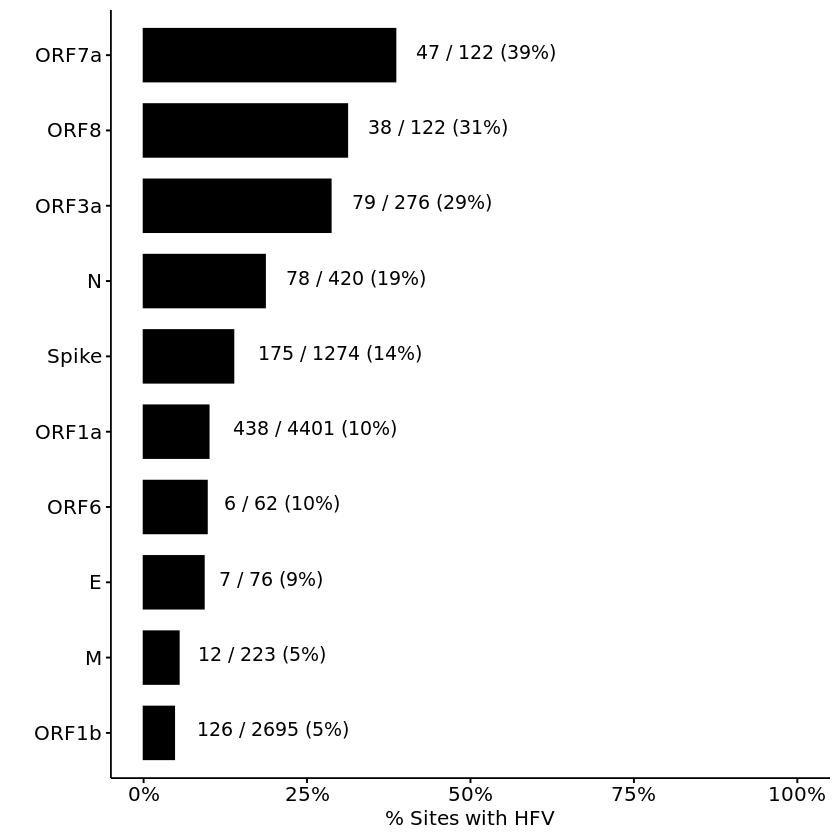

In [32]:
p <- all_mutation_list %>%
    filter(count > HFV_threshold) %>%
    filter(!duplicated(paste0(Protein, ":", site))) %>%
    mutate(
        Gene = case_when(
            !(Protein %in% (orf1ab_tbl %>% pull(Product))) ~ Protein,
            Protein %in% (orf1ab_tbl %>% filter(score == "ORF1a") %>% pull(Product)) ~ "ORF1a",
            Protein %in% (orf1ab_tbl %>% filter(score == "ORF1b") %>% pull(Product)) ~ "ORF1b"
        )
    ) %>%
    count(Gene) %>%
    mutate(
        len = sapply(Gene, function(x){
            if(x == "ORF1a"){return(4401)}
            if(x=="ORF1b"){return(2695)}
            return(fubar_output %>% filter(gene == x) %>% pull(site) %>% max())
        }),
        pct = n/len,
        lab = paste0(n, " / ", len, " (", round(pct, 2) * 100, "%)")
    ) %>%
    filter(len!=0 & abs(len)!=Inf) %>%
    arrange(pct) %>%
    ggbarplot(
        x = "Gene",
        y  = "pct",
        label = "lab",
        lab.vjust = 0.25,
        lab.hjust = -0.15,
        fill = "black"
    ) +
    coord_flip() +
    labs(
        x = "",
        y = "% Sites with HFV"
    ) +
    scale_y_continuous(labels = scales::percent, limits = c(0,1))

p


In [31]:
protein_summary_df <- all_mutation_list %>%
    filter(count > HFV_threshold & Protein != "ORF7b") %>%
    filter(!duplicated(paste0(Protein, ":", site))) %>%
    count(Protein, len) %>%
    mutate(
        n_HFV = sapply(Protein, function(x) all_mutation_list %>% filter(Protein == x & count > HFV_threshold) %>% nrow()),
        n_pos_selection = sapply(Protein, function(x) fubar_output %>% filter(protein == x & `Prob[alpha<beta]` >= 0.9) %>% nrow()),
        n_neg_selection = sapply(Protein, function(x) fubar_output %>% filter(protein == x & `Prob[alpha>beta]` >= 0.9) %>% nrow()),
        n_pct = round(n/len, 4),
        n_pos_selection_pct = round(n_pos_selection/len, 4),
        n_neg_selection_pct = round(n_neg_selection/len, 4)
    ) %>%
     select(Protein, len, n_HFV, n, n_pct, n_pos_selection, n_pos_selection_pct, n_neg_selection, n_neg_selection_pct) %>%
    dplyr::rename(
        `Protein Length` = len,
        `Number of HFV` = n_HFV, 
        `Number of Sites with HFV` = n, 
        `Percent of Sites with HFV` = n_pct, 
        `Number of Sites under Diversifying Selection` = n_pos_selection,
        `Percent of Sites under Diversifying Selection` = n_pos_selection_pct,
        `Number of Sites under Purifying Selection` = n_neg_selection,
        `Percent of Sites under Purifying Selection` = n_neg_selection_pct
    ) %>% arrange(Protein)


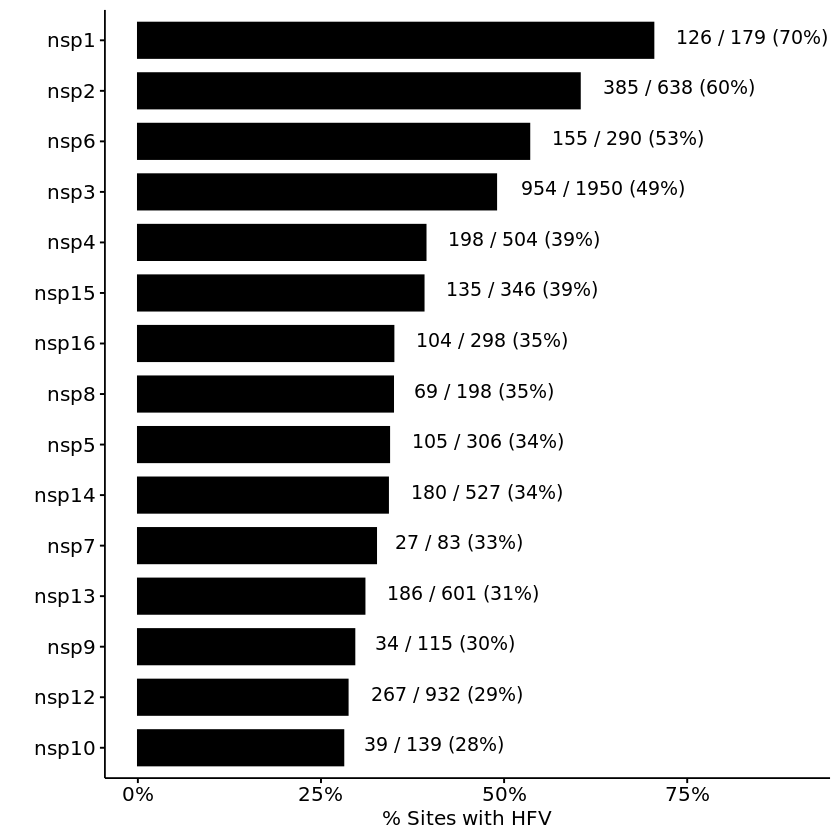

In [38]:
p <- all_mutation_list %>%
    filter(count > 1000 & Protein %in% orf1ab_map$Protein) %>%
    filter(!duplicated(paste0(Protein, ":", site))) %>%
    count(Protein) %>%
    mutate(
        len = sapply(Protein, function(x) all_mutation_list %>% filter(Protein == x) %>% pull(site) %>% max()),
        pct = n/len,2,
        lab = paste0(n, " / ", len, " (", round(pct, 2) * 100, "%)")
    ) %>%
    arrange(pct) %>%
    ggbarplot(
        x = "Protein",
        y  = "pct",
        label = "lab",
        lab.vjust = 0.25,
        lab.hjust = -0.15,
        fill = "black"
    ) +
    coord_flip() +
    labs(
        x = "",
        y = "% Sites with HFV"
    ) +
    scale_y_continuous(labels = scales::percent, limits = c(0,0.9))
        
p